In [1]:
from __future__ import absolute_import
import sys
print(sys.path)
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, TimeDistributed, Dense, Lambda, concatenate, Dropout, BatchNormalization
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelEncoder
import os
from tensorflow.keras.layers import LeakyReLU
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, accuracy_score , recall_score , precision_score
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

['/home/magupta/anaconda3/envs/stackoverflow_env/RedHat', '/usr/lib64/python37.zip', '/usr/lib64/python3.7', '/usr/lib64/python3.7/lib-dynload', '', '/home/magupta/.local/lib/python3.7/site-packages', '/usr/local/lib64/python3.7/site-packages', '/usr/local/lib/python3.7/site-packages', '/usr/lib64/python3.7/site-packages', '/usr/lib/python3.7/site-packages', '/usr/local/lib/python3.7/site-packages/IPython/extensions', '/home/magupta/.ipython']


In [2]:
df_full=pd.read_csv("data_stackOverflow/final_dataframe_with_1tag_onehot.csv",index_col=0)
df_full.shape

/usr/local/lib64/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


(1264212, 27)

In [3]:
label_encoder = LabelEncoder() 
df_full['maintag']= label_encoder.fit_transform(df_full['maintag'].astype(str)) 
df_full['maintag'].unique() 

array([16, 20,  4,  5,  0,  7,  3,  2, 17, 10, 11,  6, 15, 13, 18, 19, 12,
        1,  9,  8, 14])

In [4]:
label_encoder.classes_

array(['.net', 'android', 'asp.net', 'c', 'c#', 'c++', 'css', 'html',
       'ios', 'iphone', 'java', 'javascript', 'jquery', 'mysql', 'nan',
       'objective-c', 'other', 'php', 'python', 'ruby-on-rails', 'sql'],
      dtype=object)

In [5]:
score_col = [col for col in df_full if col.startswith('ques_score_')]
label_col = [col for col in df_full if col.startswith('tag_')]

In [6]:
df_full.columns

Index(['ques_title', 'ques_body', 'ques_score_bad', 'ques_score_medium',
       'ques_score_good', 'tag_.net', 'tag_android', 'tag_asp.net', 'tag_c',
       'tag_c#', 'tag_c++', 'tag_css', 'tag_html', 'tag_ios', 'tag_iphone',
       'tag_java', 'tag_javascript', 'tag_jquery', 'tag_mysql',
       'tag_objective-c', 'tag_other', 'tag_php', 'tag_python',
       'tag_ruby-on-rails', 'tag_sql', 'maintag', 'all_tags'],
      dtype='object')

In [7]:
df_full.shape

(1264212, 27)

In [8]:
df=df_full.sample(n=100000)

In [9]:
df.head(2)

,ques_title,ques_body,ques_score_bad,ques_score_medium,ques_score_good,tag_.net,tag_android,tag_asp.net,tag_c,tag_c#,...,tag_jquery,tag_mysql,tag_objective-c,tag_other,tag_php,tag_python,tag_ruby-on-rails,tag_sql,maintag,all_tags
330904,rail select associ model nest form,associ item associ exampl model pre code custo...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,19,ruby-on-rails/other/other/other
166458,touchesmov self view,i work import project job place problem i stac...,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,iphone/objective-c/other/other/other


In [10]:
train, val_test = train_test_split(df, test_size=0.2)
val,test=train_test_split(val_test, test_size=0.5)

In [11]:
c=train['ques_title'].apply(lambda x: len(str(x).split()))
d=train['ques_body'].apply(lambda x: len(str(x).split()))
c.mean(),c.max(),c.min(),d.mean(),d.max(),d.min()

(5.80565, 21, 1, 136.5811125, 4741, 1)

In [12]:
x_train = train.drop(label_col+['maintag']+['all_tags'],axis=1)
x_val = val.drop(label_col+['maintag']+['all_tags'],axis=1)
x_test = test.drop(label_col+['maintag']+['all_tags'],axis=1)
y_train_onehot = train[label_col]
y_test_onehot = test[label_col]
y_val_onehot = val[label_col]
y_train_multiclass = train['maintag']
y_test_multiclass = test['maintag']
y_val_multiclass = val['maintag']

In [13]:
y_train_onehot.shape

(80000, 20)

In [14]:
x_train.head(2)

,ques_title,ques_body,ques_score_bad,ques_score_medium,ques_score_good
136572,get backward window cycl cmd shift work emac app,cmd work fine tri cmd shift get messag undefin,0,1,0
1167204,django updat creat,i model pre code class xyz model model uniqu c...,1,0,0


In [15]:
y_train_onehot.head(2)

,tag_.net,tag_android,tag_asp.net,tag_c,tag_c#,tag_c++,tag_css,tag_html,tag_ios,tag_iphone,tag_java,tag_javascript,tag_jquery,tag_mysql,tag_objective-c,tag_other,tag_php,tag_python,tag_ruby-on-rails,tag_sql
136572,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1167204,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [16]:
nb_words = 30000
EMBEDDING_DIM = 50
MAX_SEQUENCE_LENGTH_1=20
MAX_SEQUENCE_LENGTH_2=150
DROPOUT = 0.1
num_epoch=20

In [17]:
tokenizer = Tokenizer(lower=True,num_words=nb_words) 
tokenizer.fit_on_texts(np.concatenate((x_train.ques_title.astype(str), x_train.ques_body.astype(str)), axis=0))

sequences_train_q1 = tokenizer.texts_to_sequences(x_train.ques_title.astype(str))
sequences_train_q2 = tokenizer.texts_to_sequences(x_train.ques_body.astype(str))

sequences_val_q1 = tokenizer.texts_to_sequences(x_val.ques_title.astype(str))
sequences_val_q2 = tokenizer.texts_to_sequences(x_val.ques_body.astype(str))

word_index = tokenizer.word_index

In [18]:
len(word_index)

269639

In [19]:
sequences_train_q1_padded = pad_sequences(sequences_train_q1, maxlen=MAX_SEQUENCE_LENGTH_1)
sequences_train_q2_padded = pad_sequences(sequences_train_q2, maxlen=MAX_SEQUENCE_LENGTH_2)

sequences_val_q1_padded = pad_sequences(sequences_val_q1, maxlen=MAX_SEQUENCE_LENGTH_1)
sequences_val_q2_padded = pad_sequences(sequences_val_q2, maxlen=MAX_SEQUENCE_LENGTH_2)

In [22]:
word_embedding_matrix = np.zeros((nb_words+1, EMBEDDING_DIM))

embeddings_index = {}

f = open('glove.6B.50d.txt')

for line in f:
    values = line.split()
    word = values[0]       
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
    
f.close()

for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        word_embedding_matrix[i] = embedding_vector

In [23]:
train_features=x_train.drop(['ques_title','ques_body'],axis=1)
val_features=x_val.drop(['ques_title','ques_body'],axis=1)
test_features=x_test.drop(['ques_title','ques_body'],axis=1)

In [24]:
train_features.shape,val_features.shape

((80000, 3), (10000, 3))

Timestamp layer wrapper applies a layer to every temporal slice of an input.
The input should be at least 3D, and the dimension of index one will be considered to be the temporal dimension.
Consider a batch of 32 samples, where each sample is a sequence of 10 vectors of 16 dimensions. The batch input shape of the layer is then (32, 10, 16), and the input_shape, not including the samples dimension, is (10, 16).
You can then use TimeDistributed to apply a Dense layer to each of the 10 timesteps, independently:

In [25]:
ques_title = Input(shape=(MAX_SEQUENCE_LENGTH_1,))
ques_body = Input(shape=(MAX_SEQUENCE_LENGTH_2,))
features  = Input(shape=(train_features.shape[1],))

q1 = Embedding(nb_words + 1, 
                 EMBEDDING_DIM, 
                 weights=[word_embedding_matrix], 
                 input_length=MAX_SEQUENCE_LENGTH_1, 
                 trainable=True)(ques_title)

q2 = Embedding(nb_words + 1, 
                 EMBEDDING_DIM, 
                 weights=[word_embedding_matrix], 
                 input_length=MAX_SEQUENCE_LENGTH_2, 
                 trainable=True)(ques_body)

shared_lstm_1=Bidirectional(LSTM(400, return_sequences=True), merge_mode="sum")
shared_lstm_2=Bidirectional(LSTM(200), merge_mode="sum")

q1 = shared_lstm_1(q1)
q1= Dropout(DROPOUT)(q1)
q1=shared_lstm_2(q1)

q2 = shared_lstm_1(q2)
q2= Dropout(DROPOUT)(q2)
q2=shared_lstm_2(q2)

merged = concatenate([q1,q2,features])

merged = Dense(1000)(merged)
merged=LeakyReLU(alpha=0.3)(merged)
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)

merged = Dense(500)(merged)
merged=LeakyReLU(alpha=0.3)(merged)
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)

merged = Dense(200)(merged)
merged=LeakyReLU(alpha=0.3)(merged)
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)

is_true_20 = Dense(20, activation='softmax')(merged)

model = Model(inputs=[ques_title,ques_body,features], outputs=[is_true_20])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 150)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 20, 50)       1500050     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 150, 50)      1500050     input_2[0][0]                    
______________________________________________________________________________________________

In [27]:
history=model.fit([sequences_train_q1_padded,sequences_train_q2_padded,x_train[score_col]], y_train_onehot, batch_size=64, epochs=10,validation_data=([sequences_val_q1_padded,sequences_val_q2_padded, x_val[score_col]],y_val_onehot))

Train on 80000 samples, validate on 10000 samples
Epoch 1/10
80000/80000 [==============================] - 1751s 22ms/sample - loss: 1.8262 - acc: 0.4644 - val_loss: 1.3596 - val_acc: 0.5762
Epoch 2/10
80000/80000 [==============================] - 1737s 22ms/sample - loss: 1.1595 - acc: 0.6145 - val_loss: 1.2997 - val_acc: 0.5863
Epoch 3/10
80000/80000 [==============================] - 1779s 22ms/sample - loss: 0.9576 - acc: 0.6687 - val_loss: 1.0537 - val_acc: 0.6439
Epoch 4/10
80000/80000 [==============================] - 1947s 24ms/sample - loss: 0.8284 - acc: 0.7077 - val_loss: 1.0967 - val_acc: 0.6486
Epoch 5/10
80000/80000 [==============================] - 1839s 23ms/sample - loss: 0.7309 - acc: 0.7401 - val_loss: 1.0692 - val_acc: 0.6483
Epoch 6/10
80000/80000 [==============================] - 1873s 23ms/sample - loss: 0.6522 - acc: 0.7682 - val_loss: 1.1242 - val_acc: 0.6415
Epoch 7/10
80000/80000 [==============================] - 1866s 23ms/sample - loss: 0.5719 - acc: 

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


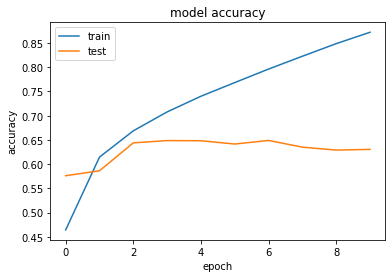

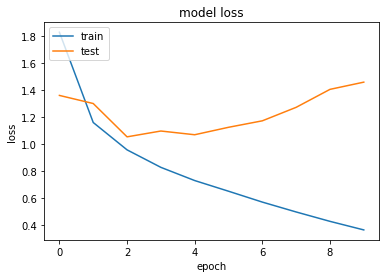

In [28]:
import matplotlib.pyplot as plt
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [30]:
sequences_test_data_q1 = tokenizer.texts_to_sequences(x_test.ques_title.astype(str))
sequences_test_data_q2 = tokenizer.texts_to_sequences(x_test.ques_body.astype(str))
sequences_test_data_q1_padded = pad_sequences(sequences_test_data_q1, maxlen=MAX_SEQUENCE_LENGTH_1)
sequences_test_data_q2_padded = pad_sequences(sequences_test_data_q2, maxlen=MAX_SEQUENCE_LENGTH_2)

In [32]:
y_pred_multiclass = model.predict([sequences_test_data_q1_padded, sequences_test_data_q2_padded,test_features])

In [33]:
y_pred_multiclass

array([[3.9749897e-09, 2.7190433e-06, 5.9435514e-09, ..., 9.9269205e-01,
        2.3494060e-05, 5.2619043e-07],
       [2.7188618e-04, 1.2672310e-06, 1.0931223e-05, ..., 8.8604320e-06,
        6.9272046e-09, 1.1333194e-05],
       [2.2515417e-07, 1.0305396e-06, 1.2762313e-06, ..., 5.0657154e-06,
        1.2917703e-04, 1.0207879e-05],
       ...,
       [7.1750937e-06, 1.6534458e-04, 1.2422693e-07, ..., 6.0076032e-05,
        8.0828919e-08, 1.2326767e-04],
       [4.3628611e-06, 2.3041633e-03, 9.0246649e-06, ..., 2.1145288e-03,
        3.9639042e-04, 8.3027629e-04],
       [1.7111513e-06, 5.8346387e-07, 1.5446674e-06, ..., 3.6001304e-05,
        2.2558075e-04, 2.5052580e-03]], dtype=float32)

In [34]:
indices_multiclass = y_pred_multiclass.argmax(axis=1)

In [35]:
report_multiclass=classification_report(y_test_multiclass, indices_multiclass)
print(report_multiclass)

              precision    recall  f1-score   support

           0       0.27      0.30      0.29        70
           1       0.73      0.77      0.75       575
           2       0.50      0.27      0.35       129
           3       0.52      0.55      0.53       141
           4       0.62      0.53      0.57       816
           5       0.71      0.57      0.63       352
           6       0.30      0.16      0.21        89
           7       0.36      0.36      0.36       148
           8       0.56      0.50      0.53       271
           9       0.42      0.31      0.36       142
          10       0.68      0.62      0.65       903
          11       0.60      0.65      0.63       964
          12       0.51      0.38      0.43       252
          13       0.53      0.51      0.52       138
          14       0.00      0.00      0.00         1
          15       0.00      0.22      0.01        81
          16       0.20      0.04      0.07      3405
          17       0.00    

/usr/local/lib64/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
model.save('multiclass_model_lstm.h5')